# Image Compression With Low Rank Approximation

### Motivation
The motivation speaks for itself here. We have all seen just how fast our image folders blow up in size as time goes on. It is advantageous to be able to represent the same image with less data. What we will do in this notebook is explore how well we can use the principal components of the image to compresses the image. Before we talk about real images, we first need to go over the math.

### Relationship to Images and Compression
We know that $A$ has $m$ rows and $n$ columns. This means that if we were store the matrix $A$ on a machine, we would have to store $mn$ elements. However, using the outer product form of $A_k$, we can see that there will be a singular value, a length $m$ vector and a length $n$ vector in the $i^{th}$ term of the summation. So, that puts us at $k(m + n + 1)$ total elements to store the rank $k$ approximation to $A$.

So, if we approximate $A$ with the best rank $\le k$ matrix $A_k$, we only need $k (m + n + 1)$ elements instead $mn$ elements for the full matrix at the cost of losing information. 

In this notebook, the matrix $A$ will represent an image with $m$ rows and $n$ columns. Each entry of $A$ will be a value between 0 and 255, representing the brightness of a grayscale pixel. 

The idea with image compression is to remove just enough information so that our eyes cannot notice the difference. So, if we approximate our matrix (image) $A$ with $A_k$, we will definitely lose quality in the resulting image. **The goal is to make $k$ as small as possible without losing too much quality.**

Let us start by importang a grayscale image of a kitten and representing the image as a numpy matrix:

### Low Rank Approximation Using Principal Components - The Math
Suppose we have a matrix $A \in \mathbb{R}^{m \times n}$ that represents a block of data (could be an image, where each entry of the matrix corresponds to a pixel value). To store A, we typicall require $mn$ real numbers. 

The SVD of $A$ is given below. We know that if we have $r$ non-zero singular values, this corresponds to a rank $r$ matrix. Therefore, $r$ columns of $U$ and $V$ respectively will matter for computing $A$. But if some of the singular values are very small, we might be able to approximately preserve $A$ while reducing the storage required for $A$. This is sometimes called 'Low Rank Approximation' since you want to go from $r$ singular values to a smaller number $k$ singular values, reducing the rank of $A$ to $k$. 

$$
\\
A = U  
\begin{bmatrix} 
    \sigma_1 & 0 & \cdots & 0 & 0\\ 
    0 & \sigma_2 & \cdots & 0 & 0\\
    & & \vdots \\ 
    & & \vdots \\ 
    0 & \cdots & \sigma_r & \cdots & 0 \\
    0 & 0 & \cdots & 0 & 0\\
    & & \vdots \\
    0  & 0 & \cdots & 0 & 0
\end{bmatrix} V^T 
\\
A = \sum_{i=1}^r \sigma_i \vec{u_i}\vec{v_i}^T
$$

We would like to  find the best rank $\le k$ approximation to $A$. Let us call this approximation $A_k$. The more mathematical formulation of $A_k$ is 

$$
\\
A_k = \underset{rank(\widehat{A_k}) \le k}{\operatorname{argmin}} ||A - \widehat{A_k}||_F.
\\
$$

If we let $A = U \Sigma V^T$, then the best rank $\le k$ approximation to A is 

$$
\\
A_k = U  
\begin{bmatrix} 
    \sigma_1 & 0 & \cdots & 0 & 0\\ 
    0 & \sigma_2 & \cdots & 0 & 0\\
    & & \vdots \\ 
    0 & \cdots & \sigma_k & \cdots & 0 \\
    0 & 0 & \cdots & 0 & 0\\
    & & \vdots \\
    0  & 0 & \cdots & 0 & 0
\end{bmatrix} V^T 
\\
A_k = \sum_{i=1}^k \sigma_i \vec{u_i}\vec{v_i}^T.
$$

Note that here we think of our principal components along both rows and columns. So columns of both $U$ and $V$ matter.

In other words, the best rank $\le k$ approximation to $A$ is the SVD of $A$, but we only keep the first $k$ singular values in the $\Sigma$ matrix and zero out all other entries.

There is a very detailed proof on why this is true that you are welcome to read if you're interested: [Low Rank Proof](https://en.wikipedia.org/wiki/Low-rank_approximation#Proof_of_Eckart%E2%80%93Young%E2%80%93Mirsky_theorem_(for_Frobenius_norm))

In [1]:
# Importing necessary libraries
from ipywidgets import *
from PIL import Image, ImageOps 
import PIL 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_image_matrix(A, title='', fig_size=(7,7)):
    plt.figure(figsize=fig_size)
    plt.title(title)
    plt.imshow(A, cmap='gray')
    plt.show()

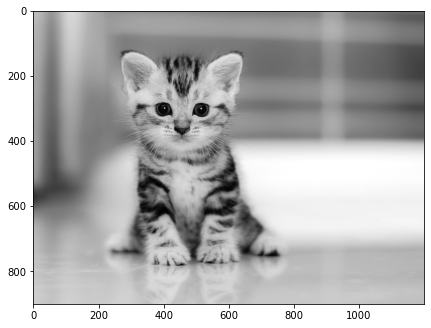

Shape of A_kitten: (901, 1200)


In [3]:
# Import the kitten
im1 = Image.open("images/kitten.PNG") 

# Convert image to matrix
A_kitten = np.array(im1)

# Plot the kitten image
plot_image_matrix(A_kitten)

# Display the dimensions of A 
print("Shape of A_kitten:", A_kitten.shape)

We see that the dimension of $A$ is $901$ by $1200$. That is, we have $901$ columns and $1200$ rows in our image. So, there are $901 * 1200 = 1081200$ pixels. This is roughly 1 megapixel, a lot of information! So, let us proceed by compressing the image via low rank approximation.

We will need to construct a function that takes in a matrix $A$ and value $k$ and return the best rank $\le k$ approximation of A. We will step through the process slowly, and the consolidate everything into this big function.

## Part 1: Coding The Low Rank Approximation

So, as we saw in the math section, we know that we need the SVD of A. We start by computing the compact SVD of A. We are not making use of the full SVD at all here, so it is more efficient to avoid the extra Gram-Schmidt step and use the compact SVD

In [4]:
# Compute U, Vt, and singular values of A
U_r, sing_vals, Vt_r = np.linalg.svd(A_kitten, full_matrices=False)

For now, let us pick the top $k=200$ singular values. We will talk more about how to choose better values of $k$ soon.

In [5]:
# Pick top k singular values
k = 200

Now we can start our approximation. Let us first repaste the mathematical expression for the rank $k$ approximation of $A$:

$$
A_k = \sum_{i=1}^{k}\sigma_i \vec{u}_i \vec{v}_i^T
$$

So, we can directly code this up and plot our resulting image:

Noticing that we need the first $k$ columns of $U$, the first $k$ rows of $V$, and the first $k$ singular values, we can store these into variables for later: 

In [6]:
# First k columns of U
U_k = U_r[:,:k]
# First k singular values
sing_vals_k = sing_vals[:k]
# First k rows of V
Vk = Vt_r[:k,:]

In [7]:
# Naive implimentation of the rank k approximation
A_k_naive = np.zeros(A_kitten.shape)
for i in range(k):
    A_k_naive += sing_vals_k[i] * np.outer(U_k[:,i], Vk[i,:])

This implementation works just fine, however it does not exploit what numpy has to offer. So instead of using a for loop, we will do the following:

In [8]:
# Better implimentation of the rank k approximation
A_k_better = np.dot(U_k * sing_vals_k, Vk)

# Make sure both implimentations agree
assert np.linalg.norm(A_k_better - A_k_naive) < 1e-9

# Use the better one from now on
A_k = A_k_better

Why is this any better? It turns out that in general we should avoid writing our own for loops for speed purposes. This is because the numpy library has knowledge of our machine and can therefore optimize something like a for loop much better than we can. This is not so important for the main idea, but now you know why we would want to use numpy functions rather than a for loop.

Now we will summarize the last few blocks into a function. Note that `return_components` will select weather we want the rank $k$ approximation or if we also want to return $\{\sigma_i\}, \{\vec{u}_i \}$ and $\{\vec{v}_i\}$ for $i = 1 \cdots k$.

In [9]:
def rank_k_approx(A, k, return_components=False):
    # Compute U, Vt, and singular values of A
    U_r, sing_vals, Vt_r = np.linalg.svd(A, full_matrices=False)
    
    # First k columns of U
    U_k = U_r[:,:k]
    # First k singular values
    sing_vals_k = sing_vals[:k]
    # First k rows of V
    Vk = Vt_r[:k,:]
    
    # Better implimentation of the rank k approximation
    A_k = np.dot(U_k * sing_vals_k, Vk)
    
    if return_components:
        # Return the approximation and the first k SVD components
        return A_k, U_k, sing_vals_k, Vk
    else:
        # Just return the rank k approximation of A
        return A_k

**Question (a):** Since we are now only using the top $k$ singular values, in terms of $k, m,$ and $n$, how many real numbers do we require to describe the rank $k$ approximation of $A$?

<span style="color:blue">**A:** (SOL) We require storage of $k(m+n+1)$ real numbers. </span>

## Part 2: Kitten Analysis

Before we start our analysis, we will write a function called `mem_savings` that will take in a matrix $A$ and value $k$ and tell us how much memory we saved using the rank $k$ approximation. Remember that we only need $k (m + n + 1)$ elements for the rank $k$ approximation and $m n$ elements for the full matrix. We will compute $100 \frac{k(m+n + 1)}{mn}$, or the percentage of the compressed data to the full data:

In [10]:
def mem_savings(A, k):
    # Get m and n
    m, n = A.shape
    
    # Rank k number of entries
    approx_ent = k * (m + n + 1)
    
    # Full matrix number of entries
    full_ent = m * n
    
    # Return percentage
    return 100 * approx_ent / full_ent

Finally, we are ready to use our functions! Let us start with $k = 200$ for the kitten and find the rank $k$ approximation for `A_kitten`:

In [11]:
# Compute rank k approximation of the kitten
A_kitten_k, Uk, sigma_k, Vk  = rank_k_approx(A_kitten, k=200, return_components=True)

Computing our memory savings:

In [12]:
pcnt_of_full = mem_savings(A_kitten, k)

And finally, lets compare the full rank and low rank images. We will also display our percent memory savings:

Using 38.88% of full image for a rank 200 approximation.


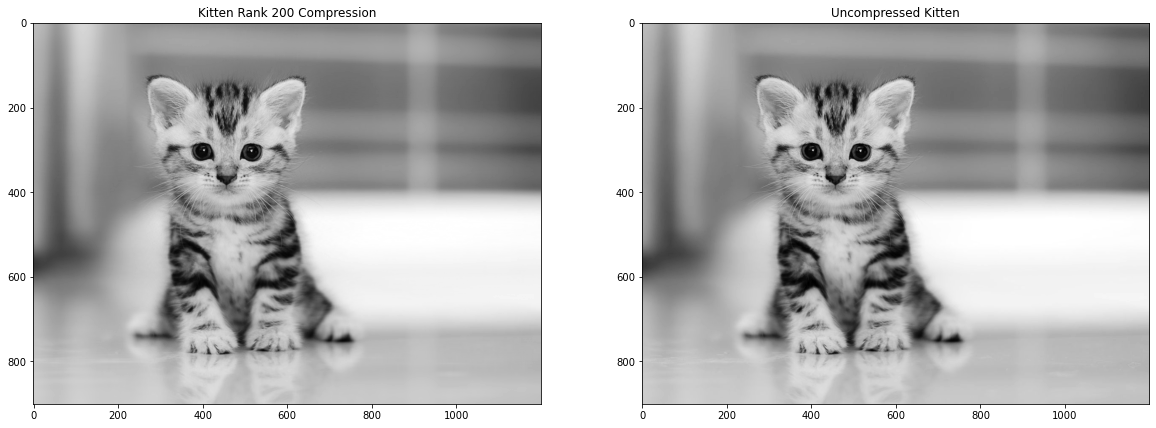

In [13]:
# Plot both pictures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot low rank
ax1.set_title(f'Kitten Rank {k} Compression')
ax1.imshow(A_kitten_k, cmap='gray')

# Plot full rank
ax2.set_title(f'Uncompressed Kitten')
ax2.imshow(A_kitten, cmap='gray')

# Memory Saved
print(f'Using {pcnt_of_full:.2f}% of full image for a rank {k} approximation.')

**Question (b):** Can you easily visually detect any difference between the two images even though we are using only about 40% of the data? 

<span style="color:blue">**A:** (SOL) We just expect that you notice very little to no change between the images. </span>

The reason why we are able to preserve image quality with only about 40% of the data is because the matrix $A$ must have that its top $k$ singular values are much larger than the remaining singular values. We will this visually in the plots.

### Choosing k


Let us talk about how to choose better values of k. Remember, we want a rank $\le k$ approximation to $A$. How do we choose $k$? It may help to recall the outer product expansion of A:

$$
A = \sum_{i=1}^{min(m,n)} \sigma_i \vec{u_i} \vec{v_i}^T
$$

We can see that looking at the distribution of the singular values will help us figure out where most of the data is captured. This is best described by a plot. We will provide both a standard and semilog plot to get the full picture:

Text(0.5, 1.0, 'log scale $i$ vs $\\sigma_i$')

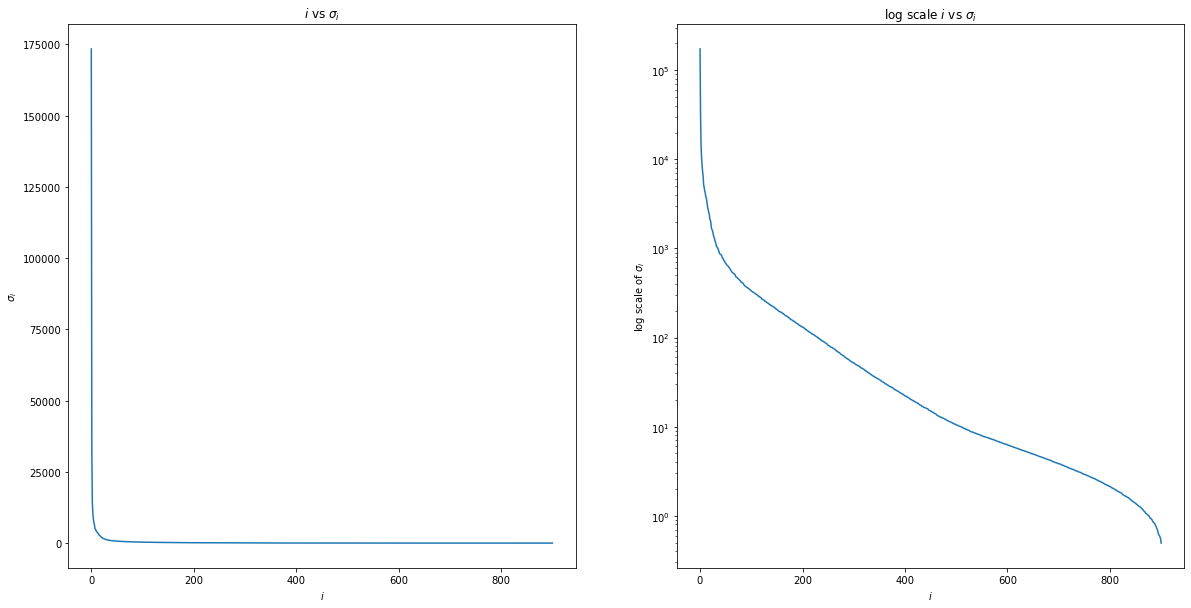

In [14]:
# Compute U, Vt, and singular values of A_kitten
U_r, sing_vals, Vt_r = np.linalg.svd(A_kitten, full_matrices=False)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot singular values - standard
ax1.plot(sing_vals)
ax1.set_xlabel("$i$")
ax1.set_ylabel("$\sigma_i$")
ax1.set_title("$i$ vs $\sigma_i$")

# Plot singular values - log
ax2.semilogy(sing_vals)
ax2.set_xlabel("$i$")
ax2.set_ylabel("log scale of $\sigma_i$")
ax2.set_title("log scale $i$ vs $\sigma_i$")

**Question (c):** Given the plots above, why did the image look so good even with only about 40% of the data? 

<span style="color:blue">**A:** (SOL) The compression worked well because the first $k=200$ singular values are much larger than the remaining singular values. </span>

Now lets figure out how varying $k$ will change the image. We have attatched a slider plot below. Try out different values of $k$ and answer the question below.

<IPython.core.display.Javascript object>


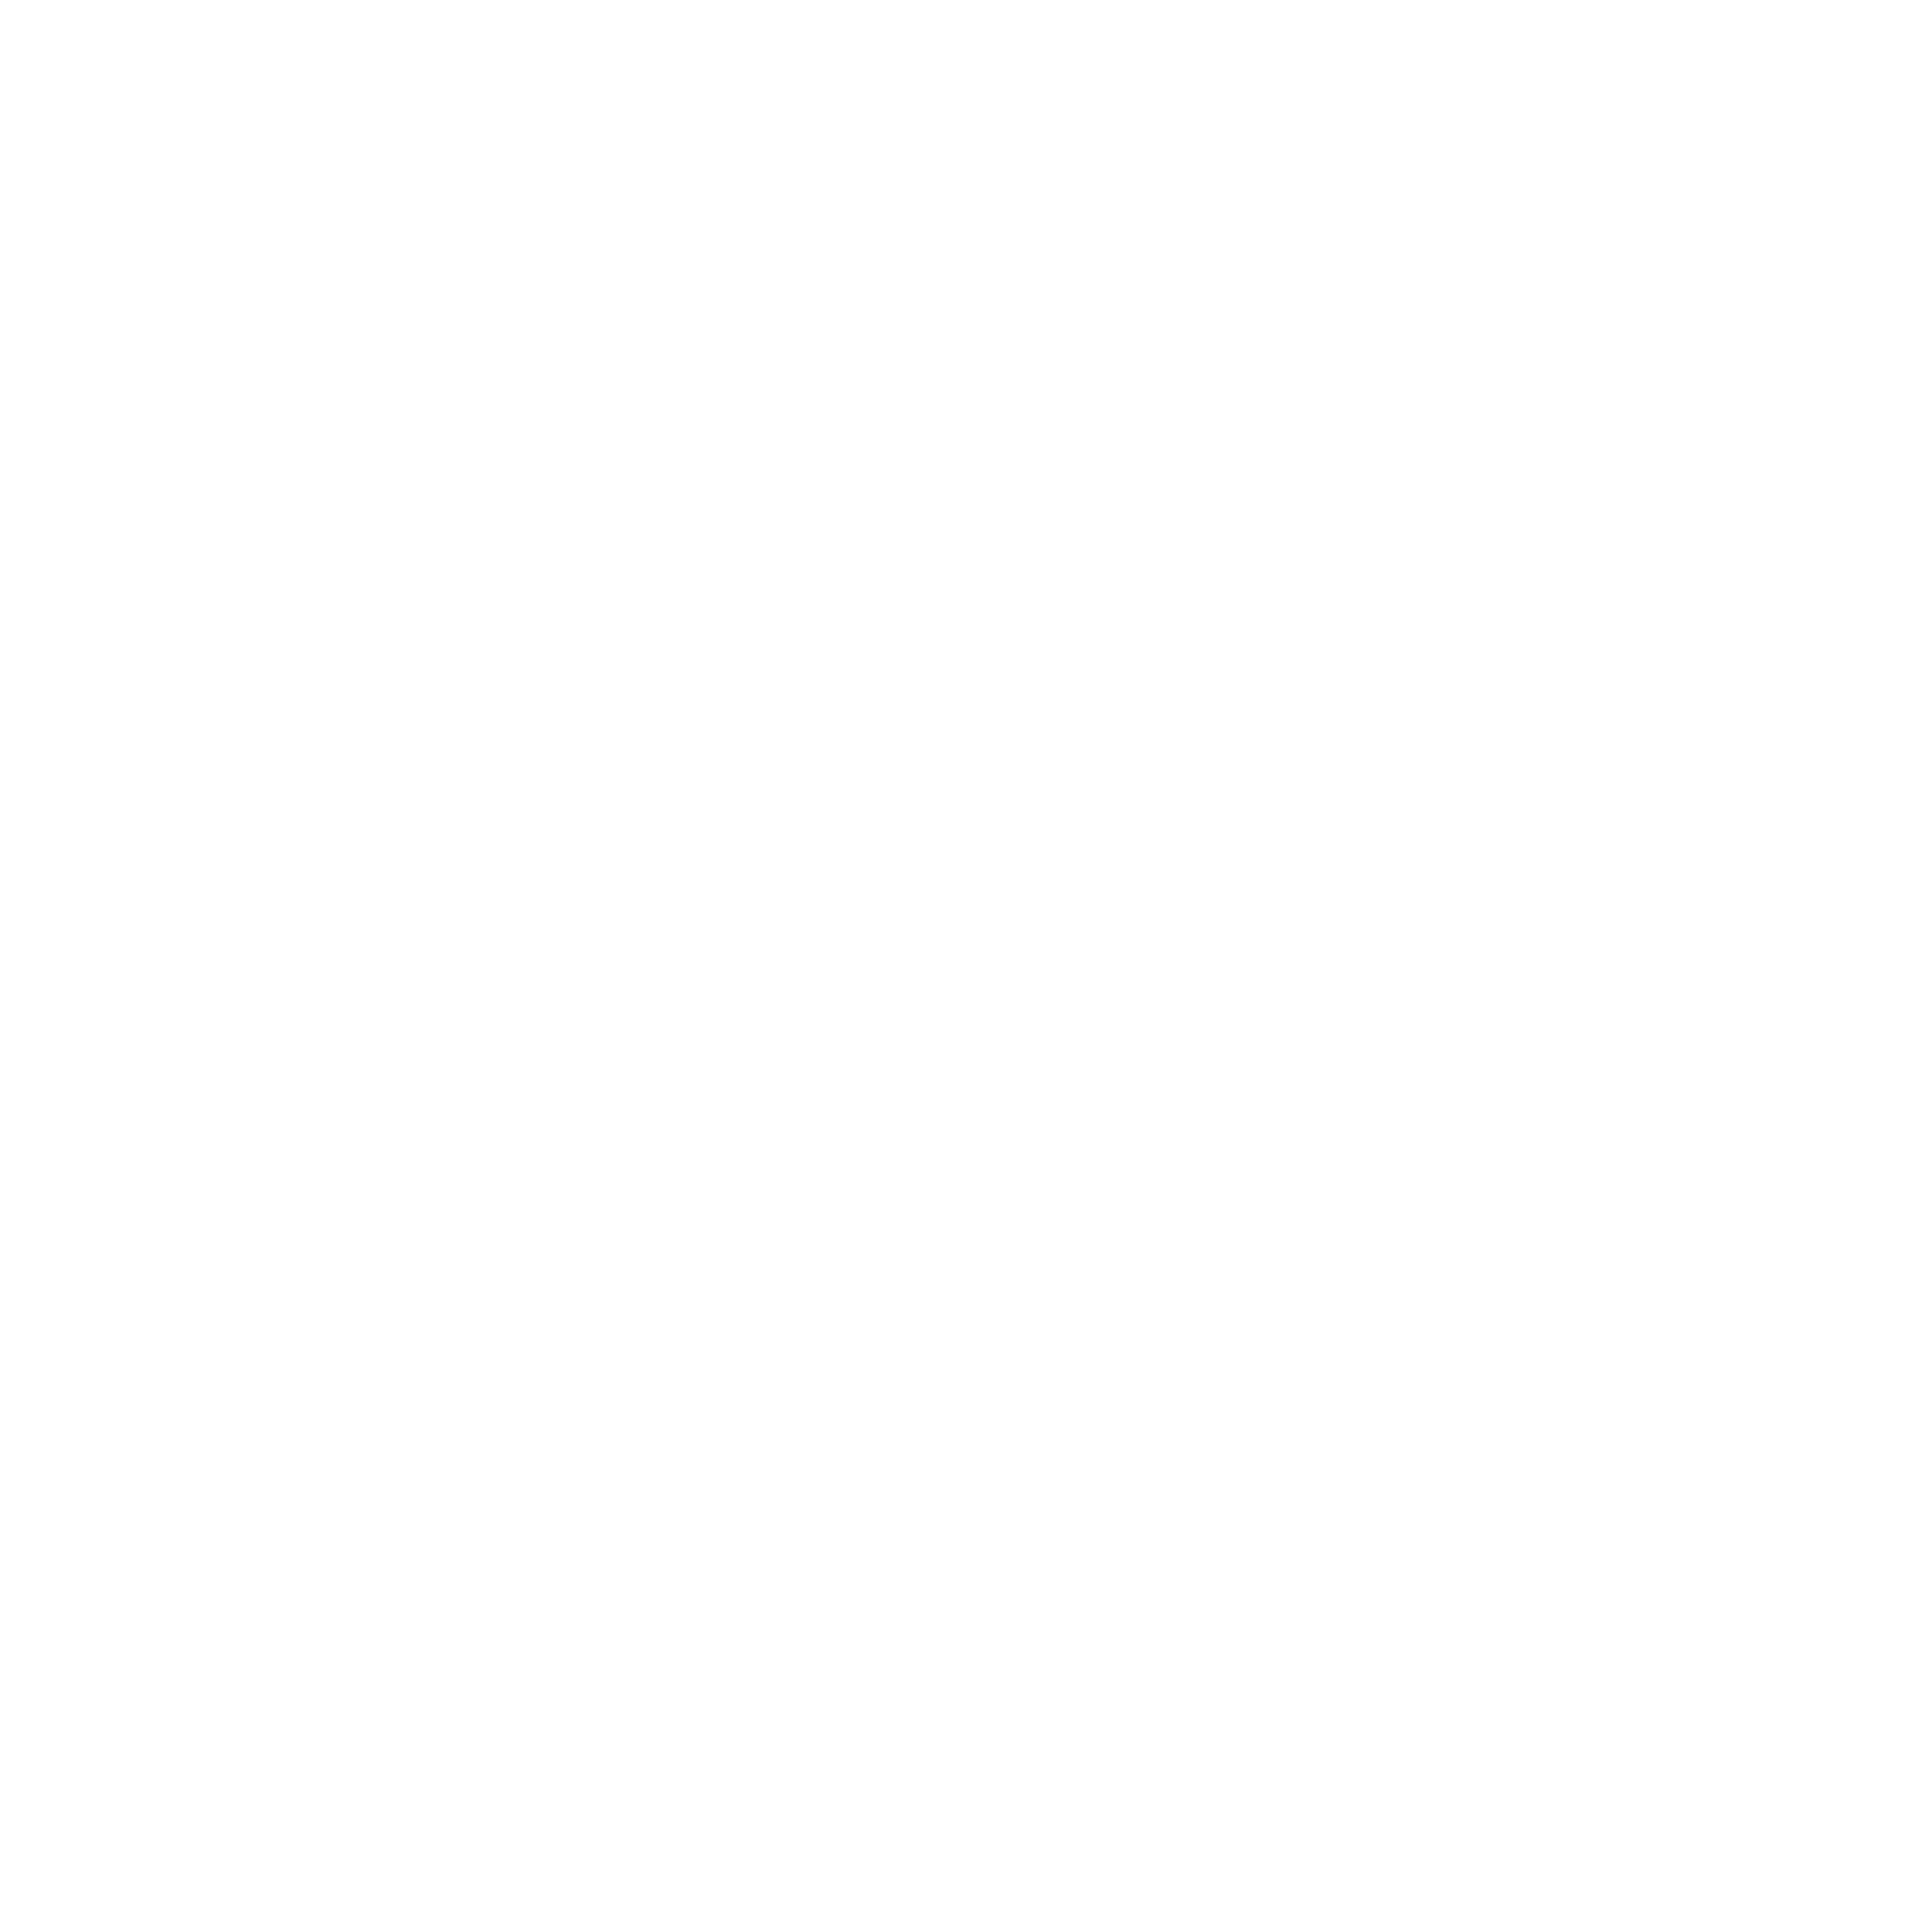

interactive(children=(IntSlider(value=0, description='k', max=200), Output()), _dom_classes=('widget-interact'…

<function __main__.update(k=1.0)>

In [15]:
# Turn on interactive plotting
%matplotlib notebook
# Setup figure 
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(A_k, cmap='gray')

# Determine slider min and max
k_min = 0
k_max = 200

# Get initial matrices
A_kitten_k, U_k, sigma_k, V_k = rank_k_approx(A_kitten, k_max, return_components=True)

# On each update we compute the low rank approximation
def update(k=1.0):
    # Compute low rank approximation
    # We are not using the low rank function here to avoid recomputing the svd everytime.
    A_k = np.dot((sigma_k * U_k)[:,:k],  V_k[:k,:])
    # Compute size
    ax.imshow(A_k, cmap='gray')
    ax.set_title(f'{mem_savings(A_kitten, k):.2f}% of total data needed')
    fig.canvas.draw_idle()

interact(update, k=widgets.IntSlider(min=k_min, max=k_max, step=1))

**Question (d):** What is the lowest acceptable value of $k$ that you can go without losing too much image quality? What were the memory savings?

**(Note)** Use your best judgment since this depends on eyesight, screen resolution, etc.

<span style="color:blue">**A:** (SOL) Playing around with the slider, $k = 75$ was the lowest we could go without noticing too much image loss. The memory savings are ~15%. </span>

## Part 3: Simpler Image Analysis - USA Flag

Now we will analyze the US flag:

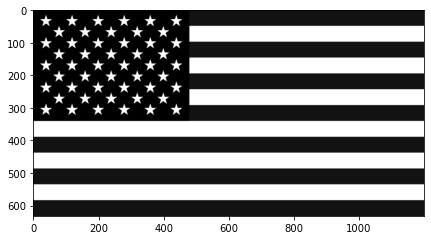

In [16]:
%matplotlib inline

# Import the flag
im1 = Image.open("images/USA.PNG") 

# Convert image to matrix
A_flag = np.array(im1)

# Show image
plot_image_matrix(A_flag)


This time we will start off by computing the SVD and plotting out the singular values:

Text(0.5, 1.0, '$i$ vs $\\sigma_i$')

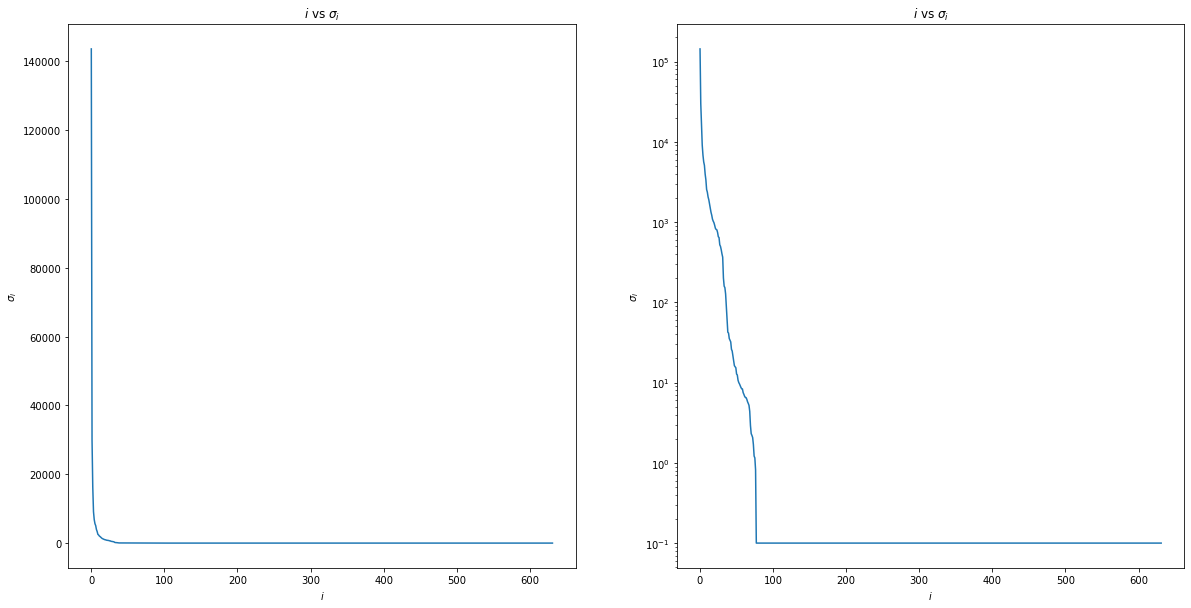

In [17]:
# Compute singular values of A_block
_, sing_vals, _ = np.linalg.svd(A_flag, full_matrices=False)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot singular values - standard
ax1.plot(sing_vals)
ax1.set_xlabel("$i$")
ax1.set_ylabel("$\sigma_i$")
ax1.set_title("$i$ vs $\sigma_i$")

# Plot singular values - log
ax2.semilogy(sing_vals + 1e-1)
ax2.set_xlabel("$i$")
ax2.set_ylabel("$\sigma_i$")
ax2.set_title("$i$ vs $\sigma_i$")

**Question (e):** What do you notice about the singular values here in comparison to the kitten's singular values? What does this mean for our low rank compression?

<span style="color:blue">**A:** (SOL) The singular values have a much sharper cutoff. This means that we can compress this image much better than the kitten. </span>

To verify your answers above, play around with the slider for the block image and then answer the questions below:

<IPython.core.display.Javascript object>


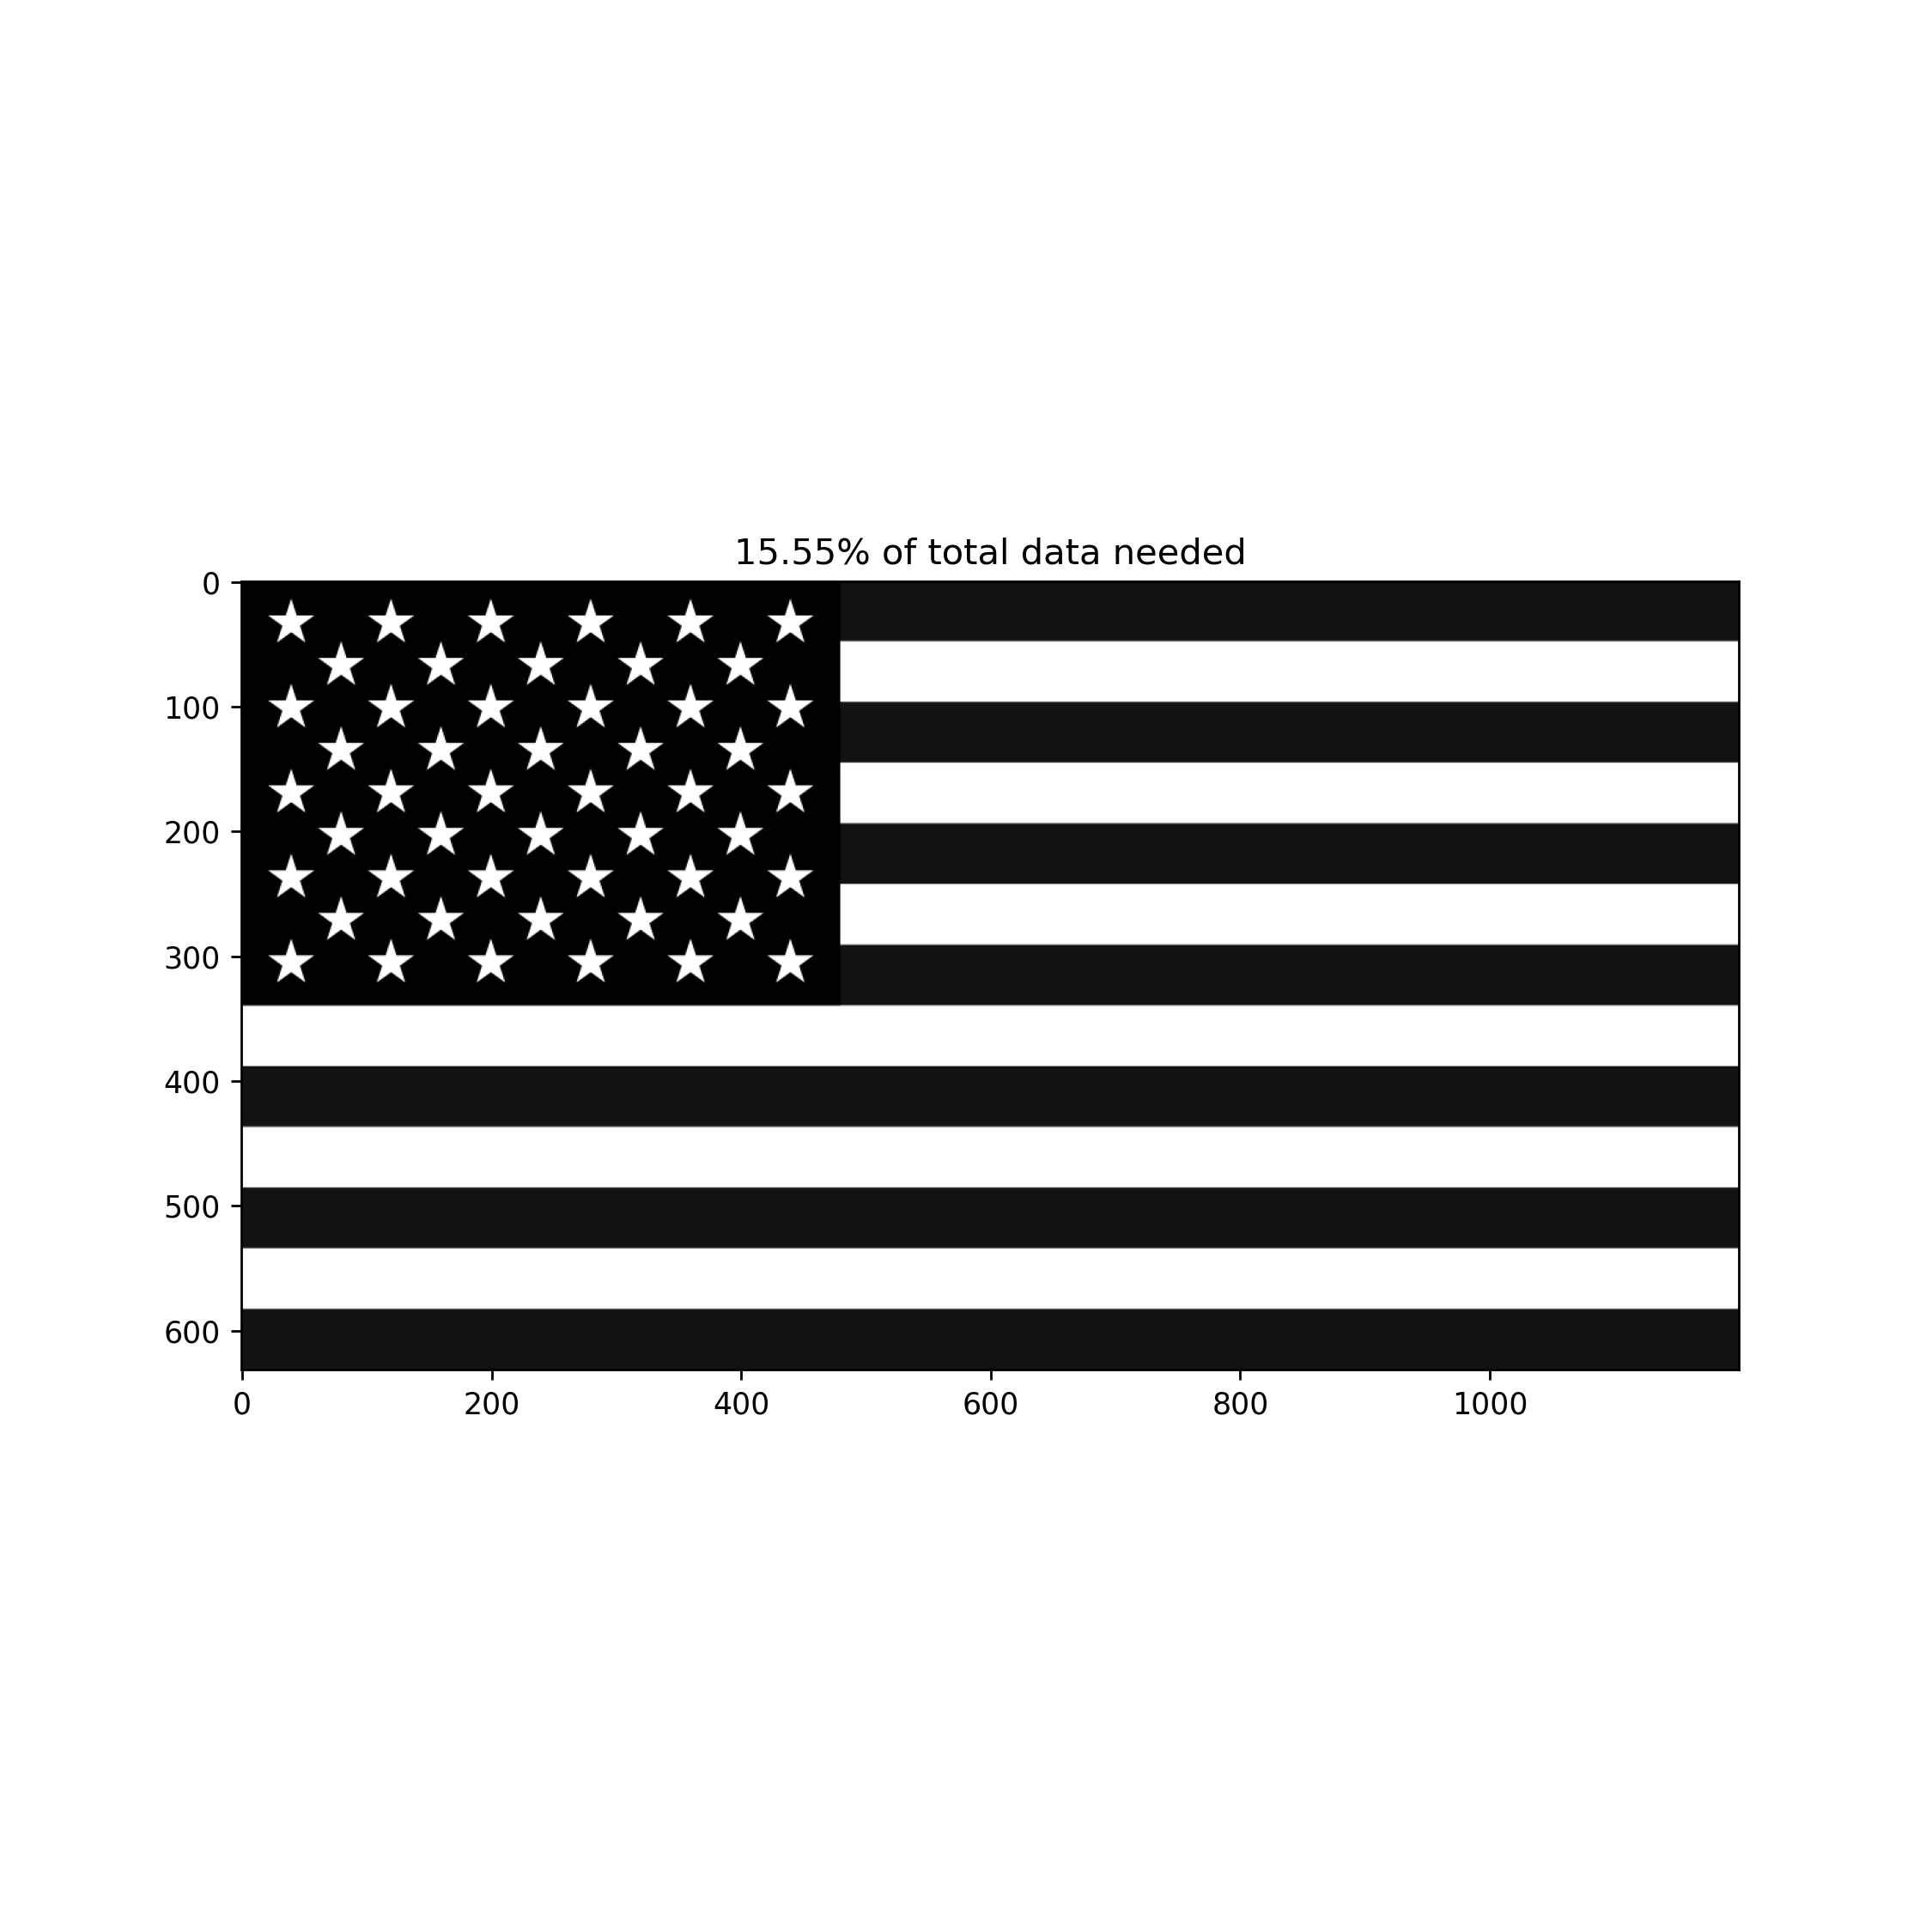

interactive(children=(IntSlider(value=0, description='k'), Output()), _dom_classes=('widget-interact',))

<function __main__.update(k=1.0)>

In [18]:
# Turn on interactive plotting
%matplotlib notebook
# Setup figure 
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(A_flag, cmap='gray')

# Determine slider min and max
k_min = 0
k_max = 100

# Get initial matrices
A_block_k, U_k, sigma_k, V_k = rank_k_approx(A_flag, k_max, return_components=True)

# On each update we compute the low rank approximation
def update(k=1.0):
    # Compute low rank approximation
    # We are not using the low rank function here to avoid recomputing the svd everytime.
    A_k = np.dot((U_k * sigma_k)[:,:k],  V_k[:k,:])
    # Compute size
    ax.imshow(A_k, cmap='gray')
    ax.set_title(f'{mem_savings(A_flag, k):.2f}% of total data needed')
    fig.canvas.draw_idle()

interact(update, k=widgets.IntSlider(min=k_min, max=k_max, step=1))

**Question (f):** What is the lowest acceptable value of $k$ here? What is the memory saving?

<span style="color:blue">**A:** (SOL) Here we can get away with $k=20$ resulting in a memory saving of ~5%! This is much better than the kitten! This is true because this image is much more structured than the kitten. </span>

Do you notice a specific structure if you set $k=1$? No need to formally answer this, just for your curiosity.

The structure we see for $k=1$ is exactly scaled versions of a vector in each column of the image. This helps us see why the flag was much more compressable than the kitten.